# Circular waveguide

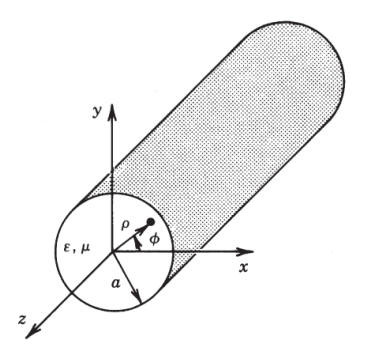

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.special import jv, jvp, yv, yvp, jn_zeros, jnp_zeros
from scipy.constants import c, pi, mu_0, epsilon_0
from numpy.lib.scimath import sqrt as csqrt

In [35]:
f = 1e9*np.linspace(1, 60, 1000)   # Frequency range
k = 2*np.pi*f/c                    # Wave number
F = 20e9                           # Operation frequency

# Guide geometry and material
r = 1e-2                         # radius

# Dielectric settings
σd = 0                             # Conductivity
ε = 1 * epsilon_0                  # Permittivity
μ = 1 * mu_0                       # Permeability
η = np.sqrt(μ/ε)                   # Intrinsic impedance

# Conductor settings
σc = 58e6                          # Conductivity (Cu)
Rs = np.sqrt(pi*μ*f/σc)         # Superficial resistance

# 1 - TE modes

## 1.1 - Propagated modes

In [36]:
def propagation_TE(F):
    modes = list(itertools.product([0,1,2,3], [1,2,3]))
    fc = np.zeros(len(modes))
    prop = np.zeros((len(modes), 3))
    
    for i in range(len(modes)):
        m, n = modes[i]
        χ = jnp_zeros(m, n)[n-1]
        kc = χ/r
        fc[i] = c*kc/(2*pi)

        if(F > fc[i]):
            prop[i,:] = np.array([m, n, fc[i]])
                
    prop = prop[~np.all(prop == 0, axis=1)]
    prop = prop[prop[:, 2].argsort()]
    
    return prop

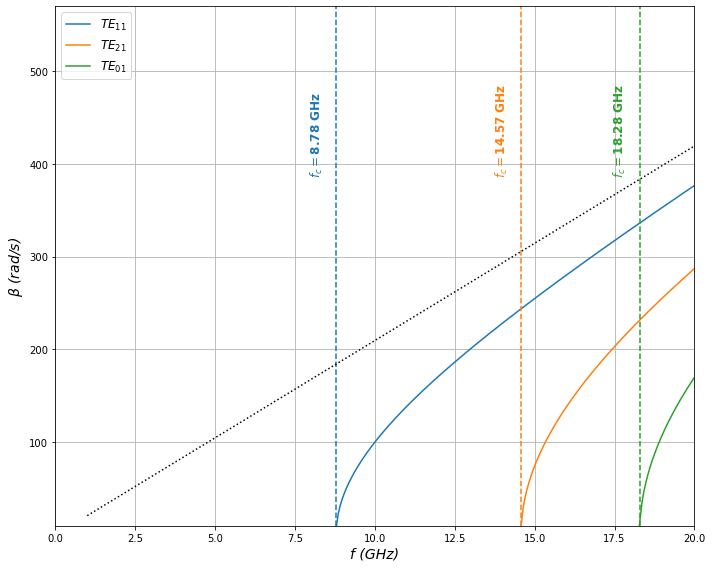

In [37]:
plt.figure(figsize = (10,8))

prop = propagation_TE(F)

for i in range(len(prop)):
    m, n = prop[i,0:2]
    fc = prop[i,2]
    
    kc = 2*pi*fc/c
    β = np.real(csqrt(k**2 - kc**2))
    
    p = plt.plot(f*1e-9, β, label = r'$TE_{'+str(int(m))+str(int(n))+'}$')
    plt.text(1e-9*fc-0.6, k[np.where(f > F)[0][0]] - 30, r'$f_c = $'+str(round(1e-9*fc,2))+' GHz',fontsize = 12, color = p[-1].get_color(),fontweight = 'bold',ha = 'center', rotation = 90) 
    plt.axvline(1e-9*fc, ls = '--', color = p[-1].get_color())
        
plt.plot(1e-9*f, k, ls = ':', color = 'k')
plt.ylabel(r'$\beta$ (rad/s)', fontsize = 14, fontstyle = 'italic')
plt.xlabel('f (GHz)', fontsize = 14, fontstyle = 'italic')
plt.xlim(0, F*1e-9)
plt.ylim(10, k[np.where(f > F)[0][0]] + 150)
plt.legend(fontsize = 12)
plt.grid()
plt.tight_layout()

# 1.2 - Losses by the conductor

<ipython-input-38-35d0026f0c8b>:11: RuntimeWarning: divide by zero encountered in true_divide
  αc = Rs/(r*η*β/k) * ( (fc/f)**2  + m**2 / (χ**2 - m**2) )
<ipython-input-38-35d0026f0c8b>:11: RuntimeWarning: divide by zero encountered in true_divide
  αc = Rs/(r*η*β/k) * ( (fc/f)**2  + m**2 / (χ**2 - m**2) )
<ipython-input-38-35d0026f0c8b>:11: RuntimeWarning: divide by zero encountered in true_divide
  αc = Rs/(r*η*β/k) * ( (fc/f)**2  + m**2 / (χ**2 - m**2) )


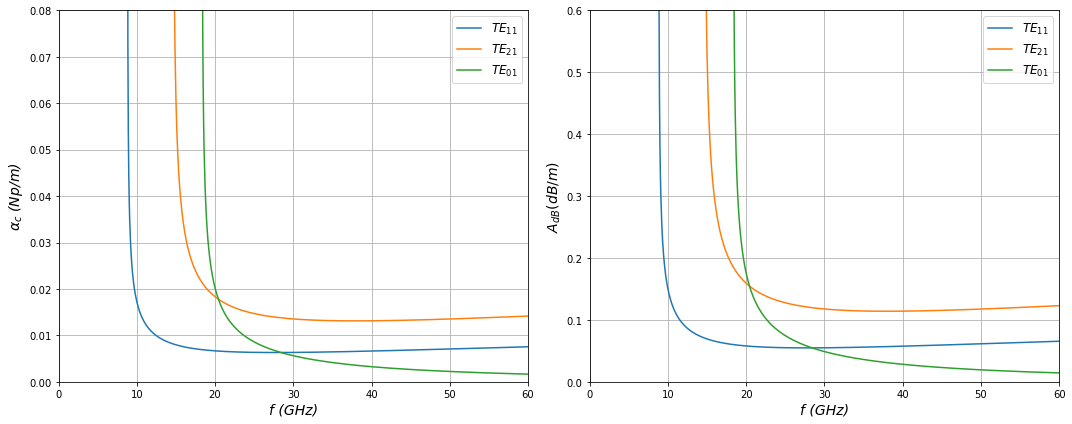

In [38]:
fig, axs = plt.subplots(1, 2, figsize = (15,6))

for i in range(len(prop)):
    m, n = prop[i,0:2]
    fc = prop[i,2]
    
    kc = 2*pi*fc/c
    χ = jnp_zeros(int(m), int(n))[int(n)-1]
    β = np.real(csqrt(k**2 - kc**2))
    
    αc = Rs/(r*η*β/k) * ( (fc/f)**2  + m**2 / (χ**2 - m**2) )
    
    #αc[αc  >  0.1] = 'NaN'
    A_dB = 20*np.log10(np.exp(αc))
    
    axs[0].plot(f*1e-9, αc, label = r'$TE_{'+str(int(m))+str(int(n))+'}$')
    axs[1].plot(f*1e-9, A_dB, label = r'$TE_{'+str(int(m))+str(int(n))+'}$')
        
axs[0].set_ylabel(r'$α_c$ (Np/m)', fontsize = 14, fontstyle = 'italic')
axs[0].set_xlabel('f (GHz)', fontsize = 14, fontstyle = 'italic')
axs[0].set_xlim(0, max(1e-9*f))
axs[0].set_ylim(0, 0.08)
axs[0].legend(fontsize = 12)
axs[0].grid()

axs[1].set_ylabel(r'$A_{dB} (dB/m)$', fontsize = 14, fontstyle = 'italic')
axs[1].set_xlabel('f (GHz)', fontsize = 14, fontstyle = 'italic')
axs[1].set_xlim(0, max(1e-9*f))
axs[1].set_ylim(0, 0.6)
axs[1].legend(fontsize = 12)
axs[1].grid()

plt.tight_layout()

## 1.3 - Field profiles

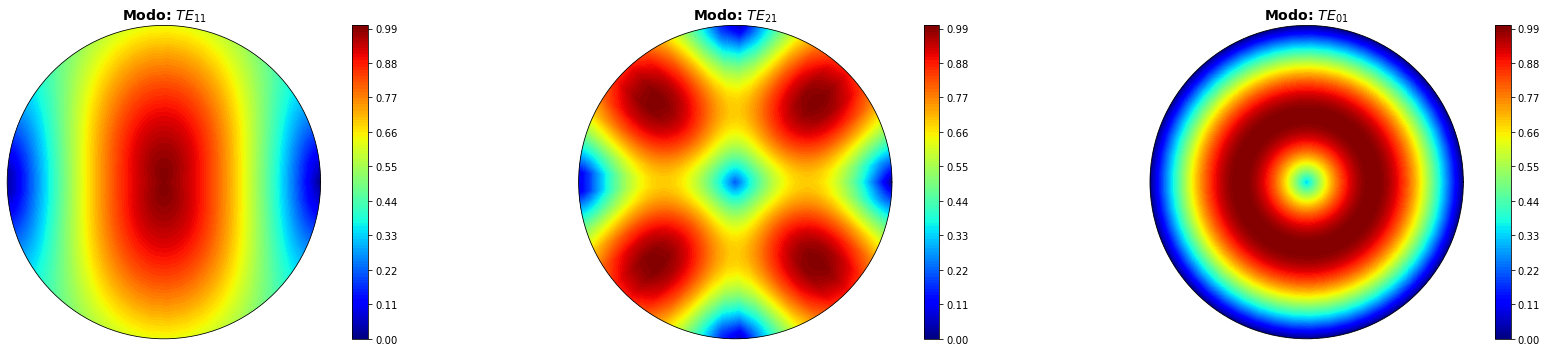

In [39]:
fig, axs = plt.subplots(1, len(prop), figsize = (25, 5),subplot_kw=dict(projection='polar'))
mycmap = plt.get_cmap('jet')

ρ = np.linspace(0.001, r, 50)
Φ = np.radians(np.linspace(0, 360, 50))
z = 0.1
ρ, Φ = np.meshgrid(ρ, Φ)

for i in range(len(prop)):
    m, n = prop[i,0:2]
    fc = prop[i,2]
    
    kc = 2*pi*fc/c
    K = 2*pi*F/c
    χ = jnp_zeros(int(m), int(n))[int(n)-1]
    β = csqrt(K**2 - kc**2)
    
    Eρ = (1j*2*np.pi*F*μ*m/(kc**2*ρ))*jv(m, kc*ρ)*np.sin(m*Φ)*np.exp(1j*β*z)
    EΦ = (1j*2*np.pi*F*μ/kc)*jvp(m, kc*ρ)*np.cos(m*Φ)*np.exp(1j*β*z)
    Ez = 0
    
    E = np.sqrt(abs(Eρ)**2 + abs(EΦ)**2 + abs(Ez)**2)
    Emax = np.max(E)
    
    field = axs[i].contourf(Φ, ρ*1e2, E/Emax, 100, cmap = mycmap, vmin = 0, vmax = 1)
    fig.colorbar(field, ax = axs[i])
    axs[i].set_title('Modo: $TE_{'+str(int(m))+str(int(n))+'}$', fontsize = 14, fontweight = 'bold')
    axs[i].grid(False)
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    
    
plt.tight_layout()

# 2 - TM modes

## 2.1 - Propagated modes

In [40]:
def propagation_TM(F):
    modes = list(itertools.product([0,1,2,3], [1,2,3]))
    fc = np.zeros(len(modes))
    prop = np.zeros((len(modes), 3))
    
    for i in range(len(modes)):
        m, n = modes[i]
        χ = jn_zeros(m, n)[n-1]
        kc = χ/r
        fc[i] = c*kc/(2*np.pi)

        if(F > fc[i]):
            prop[i,:] = np.array([m, n, fc[i]])
                
    prop = prop[~np.all(prop == 0, axis=1)]
    prop = prop[prop[:, 2].argsort()]
    
    return prop

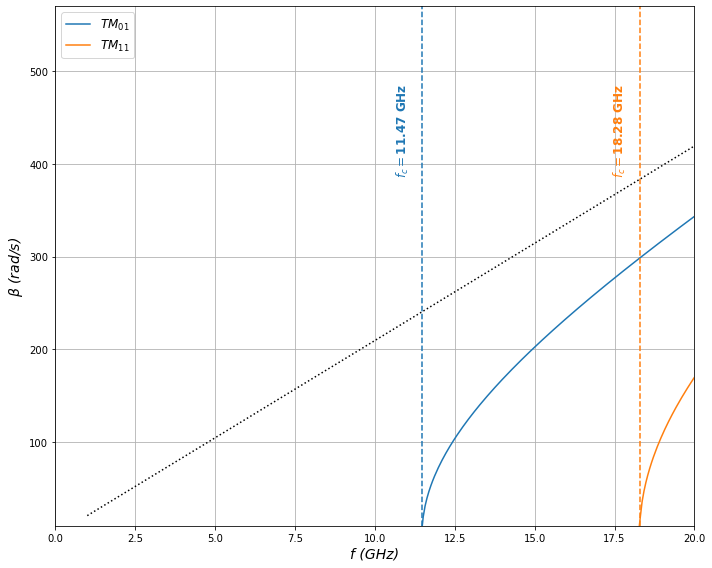

In [41]:
plt.figure(figsize = (10,8))

prop = propagation_TM(F)

for i in range(len(prop)):
    m, n = prop[i,0:2]
    fc = prop[i,2]
    
    kc = 2*pi*fc/c
    β = np.real(csqrt(k**2 - kc**2))
    
    p = plt.plot(f*1e-9, β, label = r'$TM_{'+str(int(m))+str(int(n))+'}$')
    plt.text(1e-9*fc-0.6, k[np.where(f > F)[0][0]] - 30, r'$f_c = $'+str(round(1e-9*fc,2))+' GHz',fontsize = 12, color = p[-1].get_color(),fontweight = 'bold',ha = 'center', rotation = 90) 
    plt.axvline(1e-9*fc, ls = '--', color = p[-1].get_color())
        
plt.plot(1e-9*f, k, ls = ':', color = 'k')
plt.ylabel(r'$\beta$ (rad/s)', fontsize = 14, fontstyle = 'italic')
plt.xlabel('f (GHz)', fontsize = 14, fontstyle = 'italic')
plt.xlim(0, F*1e-9)
plt.ylim(10, k[np.where(f > F)[0][0]] + 150)
plt.legend(fontsize = 12)
plt.grid()
plt.tight_layout()

## 2.2 - Losses by the conductor

<ipython-input-42-116c6e6e1803>:11: RuntimeWarning: divide by zero encountered in true_divide
  αc = Rs/(r*η*β/k)
<ipython-input-42-116c6e6e1803>:11: RuntimeWarning: divide by zero encountered in true_divide
  αc = Rs/(r*η*β/k)


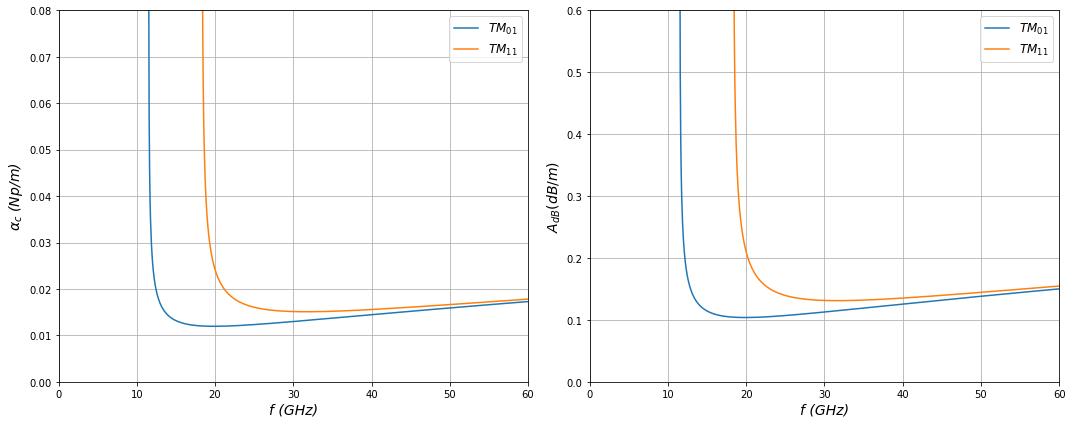

In [42]:
fig, axs = plt.subplots(1, 2, figsize = (15,6))

for i in range(len(prop)):
    m, n = prop[i,0:2]
    fc = prop[i,2]
    
    kc = 2*pi*fc/c
    χ = jn_zeros(int(m), int(n))[int(n)-1]
    β = np.real(csqrt(k**2 - kc**2))
    
    αc = Rs/(r*η*β/k)
    A_dB = 20*np.log10(np.exp(αc))
    
    axs[0].plot(f*1e-9, αc, label = r'$TM_{'+str(int(m))+str(int(n))+'}$')
    axs[1].plot(f*1e-9, A_dB, label = r'$TM_{'+str(int(m))+str(int(n))+'}$')
        
axs[0].set_ylabel(r'$α_c$ (Np/m)', fontsize = 14, fontstyle = 'italic')
axs[0].set_xlabel('f (GHz)', fontsize = 14, fontstyle = 'italic')
axs[0].set_xlim(0, max(1e-9*f))
axs[0].set_ylim(0, 0.08)
axs[0].legend(fontsize = 12)
axs[0].grid()

axs[1].set_ylabel(r'$A_{dB} (dB/m)$', fontsize = 14, fontstyle = 'italic')
axs[1].set_xlabel('f (GHz)', fontsize = 14, fontstyle = 'italic')
axs[1].set_xlim(0, max(1e-9*f))
axs[1].set_ylim(0, 0.6)
axs[1].legend(fontsize = 12)
axs[1].grid()

plt.tight_layout()

## 2.3 - Field profiles

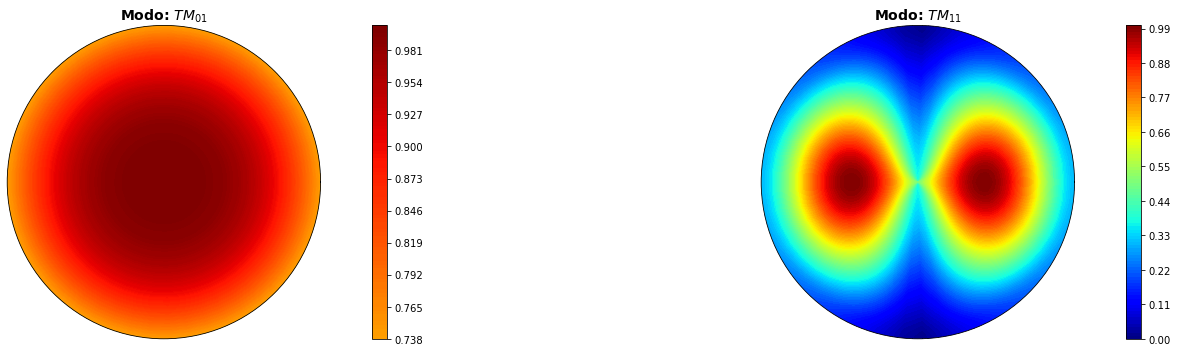

In [43]:
fig, axs = plt.subplots(1, len(prop), figsize = (25, 5),subplot_kw=dict(projection='polar'))
mycmap = plt.get_cmap('jet')

ρ = np.linspace(0.001, r, 50)
Φ = np.radians(np.linspace(0, 360, 50))
z = 0.1
ρ, Φ = np.meshgrid(ρ, Φ)

for i in range(len(prop)):
    m, n = prop[i,0:2]
    fc = prop[i,2]
    
    kc = 2*pi*fc/c
    K = 2*pi*F/c
    χ = jn_zeros(int(m), int(n))[int(n)-1]
    β = csqrt(K**2 - kc**2)
    
    Eρ = (-1j*β/kc)*jvp(m, kc*ρ)*np.cos(m*Φ)*np.exp(1j*β*z)
    EΦ = (1j*β*m/(ρ*kc**2))*jv(m, kc*ρ)*np.sin(m*Φ)*np.exp(1j*β*z)
    Ez = jv(m,kc*ρ)*np.cos(m*Φ)*np.exp(1j*β*z)
    
    E = np.sqrt(abs(Eρ)**2 + abs(EΦ)**2 + abs(Ez)**2)
    Emax = np.max(E)
    
    field = axs[i].contourf(Φ, ρ*1e2, E/Emax, 100, cmap = mycmap, vmin = 0, vmax = 1)
    fig.colorbar(field, ax = axs[i])
    axs[i].set_title('Modo: $TM_{'+str(int(m))+str(int(n))+'}$', fontsize = 14, fontweight = 'bold')
    axs[i].grid(False)
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    
plt.tight_layout()